In [34]:
import math
import torch
import numpy as np
from torch import nn
from d2l import torch as d2l

In [35]:
max_pow = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_pow)
true_w[0:4] = [5, 1.2, -3.4, 5.6]
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
ploy_features = np.power(features, np.arange(max_pow).reshape(1, -1))
for i in range(max_pow):
    ploy_featrues[:, i] /= math.gamma(i + 1)  # gamma(n) = (n - 1)!
labels = np.dot(ploy_features, true_w)  # 真实labels
labels += np.random.normal(scale=0.1, size=labels.shape)

In [36]:
# numpy array 转换为tensor
true_w, features, ploy_features, labels = [torch.tensor(x, dtype=d2l.float32) for x in [true_w, features, ploy_features, labels]]

In [37]:
features[0:2], ploy_features[0:2], labels[0:2]

(tensor([[0.1795],
         [1.4697]]),
 tensor([[1.0000e+00, 1.7954e-01, 3.2233e-02, 5.7871e-03, 1.0390e-03, 1.8654e-04,
          3.3490e-05, 6.0127e-06, 1.0795e-06, 1.9381e-07, 3.4796e-08, 6.2471e-09,
          1.1216e-09, 2.0136e-10, 3.6152e-11, 6.4906e-12, 1.1653e-12, 2.0922e-13,
          3.7562e-14, 6.7437e-15],
         [1.0000e+00, 1.4697e+00, 2.1600e+00, 3.1744e+00, 4.6654e+00, 6.8566e+00,
          1.0077e+01, 1.4810e+01, 2.1766e+01, 3.1989e+01, 4.7013e+01, 6.9094e+01,
          1.0155e+02, 1.4924e+02, 2.1933e+02, 3.2235e+02, 4.7375e+02, 6.9626e+02,
          1.0233e+03, 1.5039e+03]]),
 tensor([ 5.0088, 17.1993]))

对模型进行训练和测试

In [38]:
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上的损失"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [42]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size, is_train=True)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e3], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), 
                                   evaluate_loss(net, test_iter, loss)))
    print('weight', net[0].weight.data.numpy())

weight [[ 5.0026326  1.1794925 -3.409691   5.617634 ]]


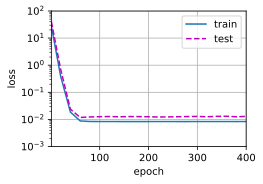

In [40]:
train(ploy_features[:n_train, 0:4], ploy_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight [[ 2.0159366 12.841696 ]]


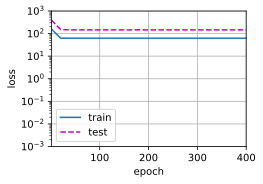

In [43]:
train(ploy_features[:n_train, :2], ploy_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan]]


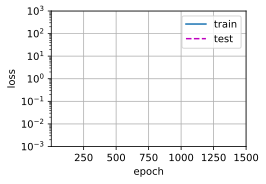

In [46]:
train(ploy_features[:n_train, :], ploy_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)